# 2023/05 Covid-19 infection

Code by GPT-4 with minor tweaks, such as extracting methods.

In [45]:
ibuprofen_doses = """
2023-05-22T22:15:00 400
2023-05-22T22:55:00 400
2023-05-23T16:00:00 800
2023-05-24T06:40:00 200
2023-05-24T22:00:00 200
"""
temperature_measurements = """
2023-05-22T21:50:00 39,6
2023-05-22T22:45:00 39,6
2023-05-23T09:15:00 37,8
2023-05-23T10:00:00 37,8
2023-05-23T11:00:00 38,4
2023-05-23T12:00:00 38,7
2023-05-23T13:00:00 39,4
2023-05-23T14:00:00 39,8
2023-05-23T15:00:00 39,7
2023-05-23T16:00:00 40,0
2023-05-23T17:00:00 39,9
2023-05-23T18:00:00 38,2
2023-05-23T19:00:00 37,7
2023-05-23T20:20:00 37,2
2023-05-23T21:00:00 37,5
2023-05-23T22:22:00 37,3
2023-05-23T23:00:00 37,4
2023-05-24T04:22:00 38,9
2023-05-24T06:30:00 39,2
2023-05-24T07:00:00 39,0
2023-05-24T08:00:00 38,2
2023-05-24T09:00:00 37,9
2023-05-24T10:00:00 37,3
2023-05-24T11:00:00 37,8
2023-05-24T12:00:00 37,7
2023-05-24T13:00:00 37,5
2023-05-24T14:00:00 37,6
2023-05-24T15:00:00 37,5
2023-05-24T16:00:00 37,4
2023-05-24T17:00:00 37,8
2023-05-24T18:00:00 37,8
2023-05-24T19:00:00 38,2
2023-05-24T20:00:00 38,2
2023-05-24T21:00:00 38,0
2023-05-24T22:00:00 38,0
2023-05-25T09:00:00 37,8
2023-05-25T10:00:00 37,5
2023-05-25T11:00:00 37,6
2023-05-25T12:10:00 37,9
2023-05-25T13:00:00 37,7
2023-05-25T14:20:00 37,7
2023-05-25T15:00:00 37,9
2023-05-25T16:00:00 37,7
2023-05-25T17:00:00 37,7
2023-05-25T18:00:00 37,9
2023-05-25T19:00:00 38,1
2023-05-25T20:00:00 38,0
2023-05-25T21:00:00 38,0
2023-05-25T22:00:00 38,0
2023-05-25T23:00:00 37,8
2023-05-26T00:30:00 37,9
2023-05-26T10:00:00 37,7
2023-05-26T11:00:00 37,4
2023-05-26T12:00:00 37,4
2023-05-26T13:00:00 37,6
2023-05-26T14:00:00 37,6
2023-05-26T15:02:00 37,5
2023-05-26T16:02:00 37,4
2023-05-26T17:15 37,1
2023-05-26T18:10 37,1
"""

Data wrangling to parse the raw measurements.

In [22]:
import io
import pandas as pd

def parse_temperatures(str_data):
    # Create a DataFrame from your data
    df = pd.read_csv(io.StringIO(str_data), sep=" ", names=["date", "temperature"])
    df["date"] = pd.to_datetime(df["date"], format="ISO8601")

    # Convert temperature to float
    df["temperature"] = df["temperature"].str.replace(",", ".").astype(float)
    return df

def parse_ibuprofen_doses(str_data):
    # Create a DataFrame from your data
    df = pd.read_csv(io.StringIO(str_data), sep=" ", names=["date", "dose"])
    df["date"] = pd.to_datetime(df["date"], format="ISO8601")

    # Convert temperature to float
    df["dose"] = df["dose"].astype(int)
    return df


Calculating the amount of Ibuprofen in the body after ingestion, assuming linearly digested in 90 minutes after ingestion and decays with half-life of 2 hours.

Exponential decay is used to model the amount:

$$
A(t) = A_0*b^\frac{t}{k}
$$

Where b is the decay in given time (0.5 in this case), k is the time taken to reach that decay (2 hours) and t is the elapsed time.

In [34]:
import numpy as np

def calculate_total_amount(df, half_life=2.0):
    # Convert half_life from hours to minutes
    half_life = half_life * 60

    # Calculate start and end time for the plot
    start_time = df["date"].min()
    end_time = df["date"].max() + pd.Timedelta(hours=24)

    # Initialize the amount in the blood stream to zero for each minute in the time range
    times = pd.date_range(start_time, end_time, freq='1T')
    total_amount = pd.Series(np.zeros(len(times)), index=times)

    # Add the effect of each ingestion event
    for _, row in df.iterrows():
        ingestion_time = row["date"]
        amount_ingested = row["dose"]
        full_effect_time = ingestion_time + pd.Timedelta(minutes=90)
        if full_effect_time > end_time:
            # If the full effect is not reached during the time range, ignore this ingestion event
            continue
        decay_times, amounts = decay(ingestion_time, end_time, amount_ingested, half_life)
        total_amount.loc[decay_times] += amounts

    return total_amount

def decay(start_time, end_time, start_amount, half_life):
    absorption_start = start_time
    full_effect_start = absorption_start + pd.Timedelta(minutes=90)

    # Generate time points for each phase separately
    absorption_times = pd.date_range(absorption_start, full_effect_start, freq='1T')
    decay_times = pd.date_range(full_effect_start, end_time, freq='1T')

    # Calculate amounts for each phase
    absorption_amounts = np.linspace(0, start_amount, len(absorption_times))
    elapsed_time = (decay_times - full_effect_start).total_seconds() / 60
    decay_amounts = start_amount * 0.5**(elapsed_time / half_life)

    # Concatenate both phases
    times = absorption_times.append(decay_times)
    amounts = np.concatenate([absorption_amounts, decay_amounts])

    return times, amounts

Plot the processed data

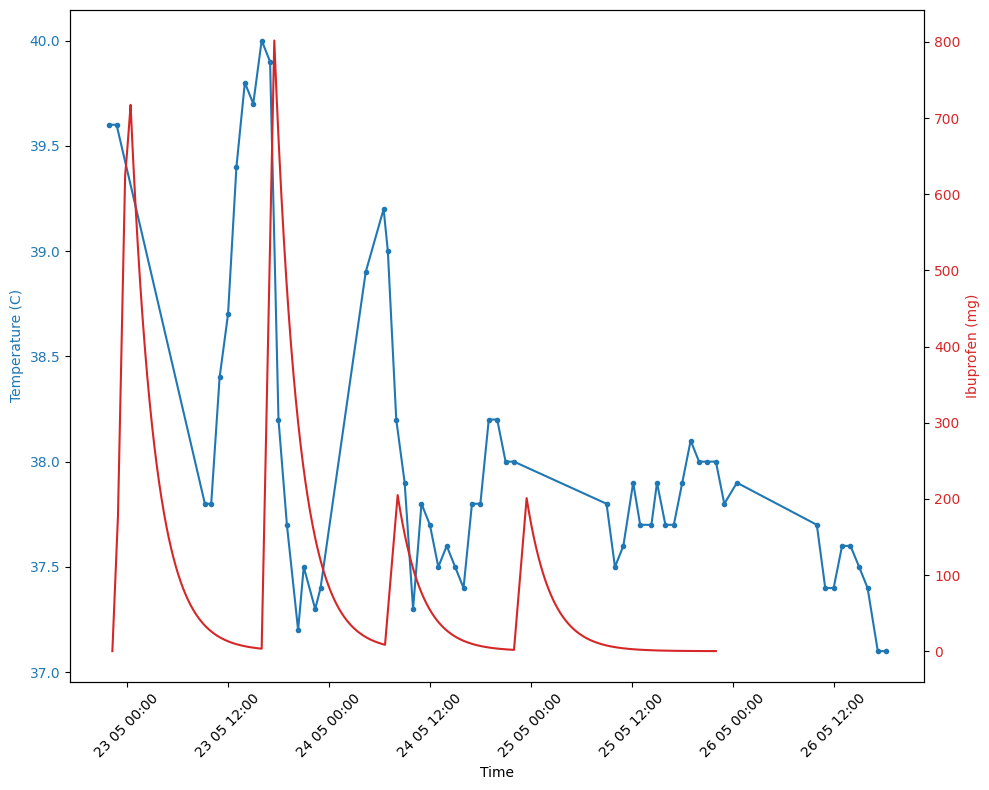

In [46]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

temperature_df = parse_temperatures(temperature_measurements)
ibuprofen_df = parse_ibuprofen_doses(ibuprofen_doses)
ibuprofen_estimation_series = calculate_total_amount(ibuprofen_df)

fig, ax1 = plt.subplots(figsize=(10,8))

# plot line graph
ax1.plot(temperature_df["date"], temperature_df["temperature"], marker=".", color='tab:blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature (C)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# format x-axis labels
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %m %H:%M'))
plt.xticks(rotation=45) # rotates x-axis labels to 45 degrees

# instantiate a second axis that shares the same x-axis
ax2 = ax1.twinx()  
ax2.set_ylabel('Ibuprofen (mg)', color='tab:red')  # we already handled the x-label with ax1
ax2.plot(ibuprofen_estimation_series.index, ibuprofen_estimation_series.values, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()